# Example Usage on ImageNet dataset

Example usages of EnsembleXAI package on the ImageNet dataset with usage of pretrained resnet50 model.

## Imports of the necessary packages

In [1]:
import gc
import os
import json
import numpy as np
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import Resize, CenterCrop
from torchvision.models import resnet50, ResNet50_Weights
from captum.attr import IntegratedGradients, Occlusion, NoiseTunnel, visualization as viz
from EnsembleXAI import Ensemble, Metrics

We can find proper names for each class id under this link.

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)

Helper functions to hasten the loading and the required image transformations.

In [3]:
def images_list(image_path, resize=True):
    _crop = CenterCrop(224).forward
    _resize = Resize([232,232]).forward
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        if resize:
            image = _crop(_resize(image))
        images.append(image)
    return images

def load_all(classid):
    all_img = images_list(images_dir + classid + "\\")[:3]
    all_img_org = images_list(images_dir + classid + "\\", resize=False)[:3]
    all_tens = [F.to_tensor(img) for img in all_img]
    all_msks = [(F.to_tensor(img)>0).float() for img in images_list(masks_dir + classid + "\\")[:3]]
    tens_img = torch.stack(all_tens)
    tens_msks = torch.stack(all_msks)
    return all_img, all_img_org, all_tens, all_msks, tens_img, tens_msks

## Loading images and plotting the examples
First setting up correct paths to masks and images is required. Masks are the ImageNetS50 masks found on (https://lusseg.github.io/), consisting of 10 pixel-perfect masks for each of 50 classes sampled from the imagenet dataset. For sake of easier visualization, we consider 3 images from the "n01491361" class which is a tiger shark class.

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = "\\".join(os.getcwd().split(sep="\\")[:-1] + ['notebooks', 'images']) + "\\"
id = "n01491361"
all_images, all_images_original, all_tensors, all_masks, tensor_images, tensor_masks = load_all("n01491361")

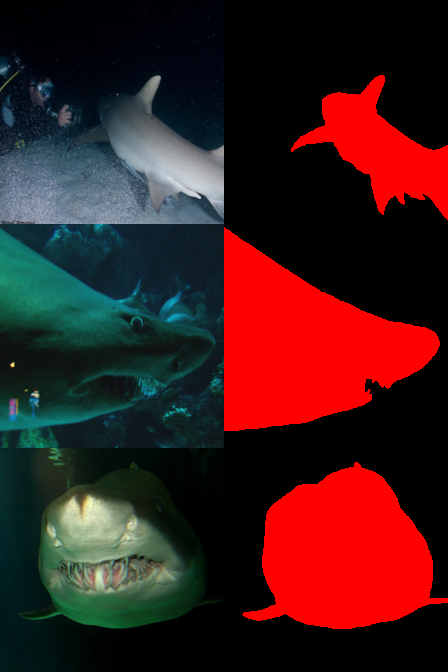

In [5]:
photos = []
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    photos.append(photo)
display(F.to_pil_image(torch.cat(photos, dim=1)))

## Model Loading
We use the resnet50 model pretrained on the imagenet dataset and generate predictions on our three images.

In [6]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet50_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])
proper_data = pipeline(all_images_original)
outputs = model(proper_data)
_, preds = torch.max(outputs, 1)
probs2 = torch.nn.functional.softmax(outputs, dim=1)

## Single Explanations

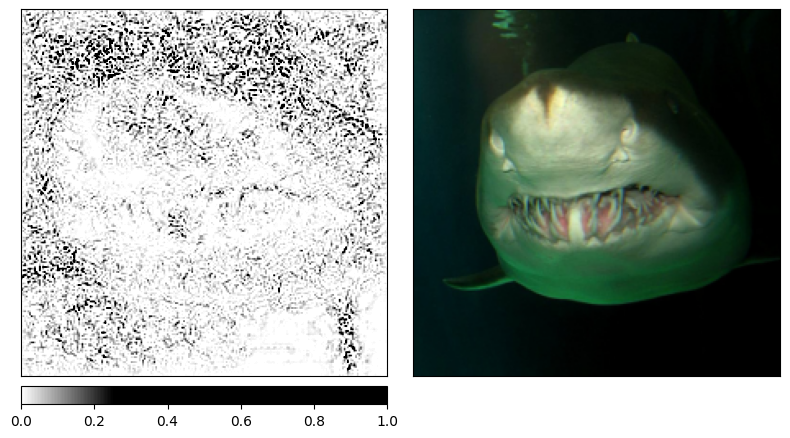

In [7]:
single_pred = preds[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)
gc.collect()
transformed_img = resnet_transform(all_images_original[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
_1 = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().numpy(), (1,2,0)),
                                      np.transpose(tensor_images[2].squeeze().numpy(), (1,2,0)),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      outlier_perc=1)

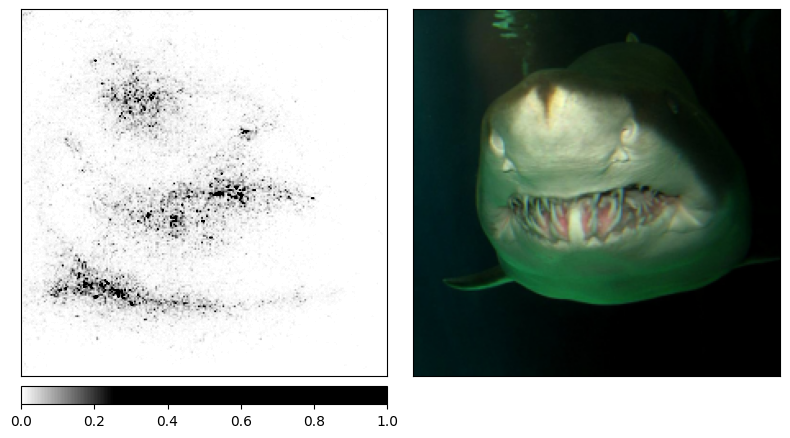

In [8]:
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)
gc.collect()
_2 = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

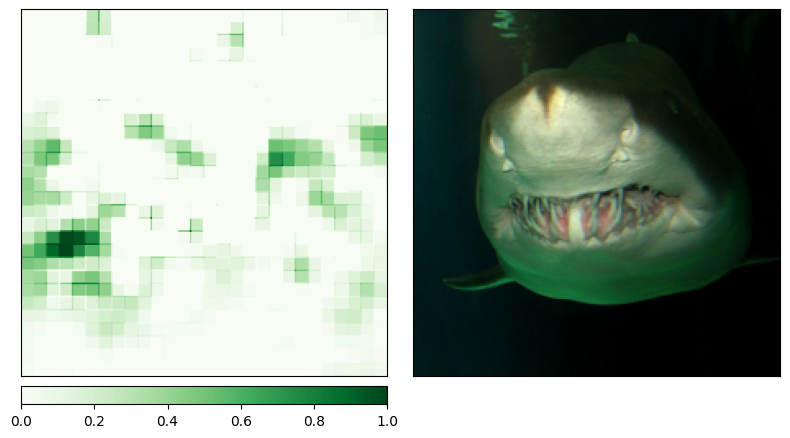

In [9]:
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)
_3 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

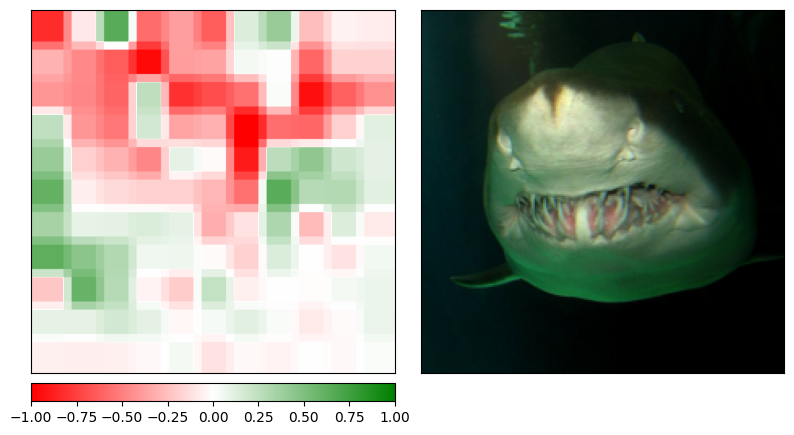

In [10]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 20, 20),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 25, 25),
                                       baselines=0)
_4 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                       np.array(all_images[2]),
                                       ["heat_map", "original_image"],
                                       ["all", "positive"],
                                       show_colorbar=True,
                                       outlier_perc=2,
                                       )

## Explanations for all 3 images
Here we create example explanations for all 3 considered images.

In [ ]:
occlusion = Occlusion(model)
attributions_occ_all_25 = occlusion.attribute(tensor_images,
                                        strides = (3, 20, 20),
                                        target = preds,
                                        sliding_window_shapes = (3, 25, 25),
                                        baselines=0)
attributions_occ_all_15 = occlusion.attribute(tensor_images,
                                           strides = (3, 8, 8),
                                           target = preds,
                                           sliding_window_shapes = (3, 15, 15),
                                           baselines=0)
attributions_ig_nt_all = torch.cat([noise_tunnel.attribute(tensor_images[i].unsqueeze(dim=0), nt_samples=5, nt_type='smoothgrad_sq', target=preds[i].unsqueeze(dim=0)) for i in range(tensor_images.shape[0])], dim=0)
gc.collect()

## Metrics for the created explanations
Calculation of consistency for the first image across both occlusion explanations.

In [53]:
Metrics.consistency(torch.stack([attributions_occ_all_15[0], attributions_occ_all_25[0]]))

0.03428497165441513

Calculation of decision impact ratio for occlusion25 explanations with threshold = 0.3. 0.33 result means that one third of the original images has change the decision after obscuring the critical area of explanation.

In [30]:
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
Metrics.decision_impact_ratio(tensor_images, predict, attributions_occ_all_25, 0.3, 0)

0.3333333432674408

Calculation of confidence impact ratio for occlusion25 explanations with threshold = 0.3. Negative value on "same_prediction" argument implies that on average the probability for the class predicted has increased after obscuring the critical area.

In [33]:
Metrics.confidence_impact_ratio(tensor_images, predict, attributions_occ_all_25, 0.3, 0, compare_to="same_prediction")

-0.004259963985532522

Calculation of confidence impact ratio for occlusion25 explanations with threshold = 0.3. Negative value on "new_prediction" argument implies that on average the maximal probability for the prediction has increased after obscuring the critical area.

In [32]:
Metrics.confidence_impact_ratio(tensor_images, predict, attributions_occ_all_25, 0.3, 0, compare_to="new_prediction")

-0.004277209285646677

Calculation of accordance recall for occlusion25. This metric calculates the area of explanation, mask intersection over the mask area. Therefore for the second image the explanation covers half of the mask area.

In [16]:
Metrics.accordance_recall(attributions_occ_all_25, tensor_masks)

tensor([0.3734, 0.5004, 0.2527])

Calculation of accordance precision for occlusion25. This metric calculates the area of explanation, mask intersection over the explanation area. Therefore for the second image the mask covers ~0.17 of the explanation area.

In [17]:
Metrics.accordance_precision(attributions_occ_all_25, tensor_masks)

tensor([0.0423, 0.1679, 0.1560])

Calculation of accordance F1 score for occlusion25. This is a average of harmonic averages of accordance precision and recall.

In [18]:
Metrics.F1_score(attributions_occ_all_25, tensor_masks)

0.1734609603881836

Calculation of average IOU for occlusion15.

In [34]:
Metrics.intersection_over_union(attributions_occ_all_15, tensor_masks)

0.0009072763496078551

In [20]:
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

0.0

## Ensembles
Ensembling with the basic functions across the 3 explanations.

In [48]:
all_stacked = torch.stack([attributions_ig_nt_all, attributions_occ_all_15, attributions_occ_all_25], dim=1)
aggreg_all1 = Ensemble.basic(all_stacked, aggregating_func='avg')
aggreg_all2 = Ensemble.basic(all_stacked, aggregating_func='min')
aggreg_all3 = Ensemble.basic(all_stacked, aggregating_func='max')
explanations_all = torch.cat([all_stacked,aggreg_all3.unsqueeze(dim=1), aggreg_all2.unsqueeze(dim=1), aggreg_all1.unsqueeze(dim=1)], dim=1)

Consistency metric without and with the ensemblings.

In [50]:
[Metrics.consistency(all_stacked[i]) for i in range(all_stacked.shape[0])]

[0.01864352449774742, 0.03320881724357605, 0.04660182073712349]

In [49]:
[Metrics.consistency(explanations_all[i]) for i in range(explanations_all.shape[0])]

[0.015071449801325798, 0.022995954379439354, 0.03292311355471611]

In [83]:
Ensemble.supervisedXAI(explanations_all.repeat(3,1,1,1,1), tensor_masks.repeat(3,1,1,1), weights='auto', n_folds=4)

ValueError: cannot reshape array of size 1354752 into shape (3,3,224,224)

In [66]:
3*3*224*224

451584

In [81]:
explanations_all.shape, tensor_masks.unsqueeze(dim=1).shape

(torch.Size([3, 6, 3, 224, 224]), torch.Size([3, 1, 3, 224, 224]))

## Plotting all explanations

In [54]:
plt.style.use('fast')
# helper function for the plotting
def plot_explanations(images, explanations, columns_names, classes_predicted, method = "heat_map"):
    cmaps=[default_cmap, None, None, None, None, None, None]
    nrow, ncol = len(images), explanations.shape[1]+1
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(14, 3*explanations.shape[0]))
    for col, col_name in zip(ax[0], columns_names):
        col.title.set_text(col_name)
    for i, img in enumerate(images):
        ax[i,0].xaxis.set_ticks_position("none")
        ax[i,0].yaxis.set_ticks_position("none")
        ax[i,0].set_yticklabels([])
        ax[i,0].set_xticklabels([])
        ax[i,0].imshow(np.array(img), vmin=0, vmax=255)
        ax[i,0].set_ylabel(classes_predicted[i], size='large')
        for j, col in enumerate(ax[i,1:]):
            expl = explanations[i,j]
            sign = "positive"
            if expl.amin() < 0:
                sign = "all"
            _ = viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                                         original_image=np.array(img),
                                         method=method,
                                         sign=sign,
                                         plt_fig_axis=(fig, col),
                                         show_colorbar=True,
                                         outlier_perc=2,
                                         cmap=cmaps[j],
                                         use_pyplot=False
                                         )
    plt.show()

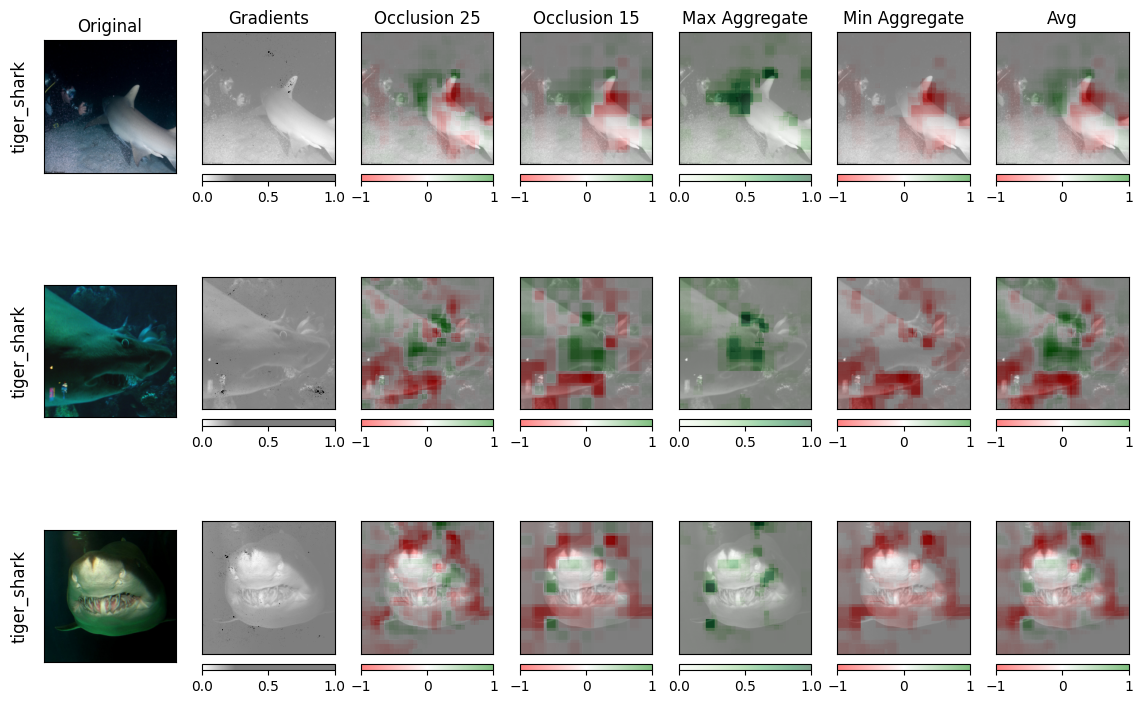

In [47]:
predicted_names = [imagenet_classes_dict[str(i.item())][1] for i in preds]
col_names = ["Original", "Gradients", "Occlusion 25","Occlusion 15", "Max Aggregate", "Min Aggregate", "Avg"]
plot_explanations(all_images, explanations_all, col_names, predicted_names, method="blended_heat_map")